In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from pathlib import Path
from typing import Sequence

%reload_ext autoreload
%autoreload 2
import pyfiles.build_vp as build_vp

# Code for getting usefull EnergyPlan `input`-data

Here all data is derives from `EnergyDataService` due to the weird nature of the KF-timeseries. Thus, I extent the ENS download to include production of VE.

## 1. EnergyDataService

I get the following dataset to describe the indicated variable:

1. 'Electricity demand' is electricity demand.
2. 'External Electricity Market price distribution' is prices
3. ...

### 1.1 general settings

In [10]:
# 1. used timeframe
start = "2023-01-01T00:00"
end   = "2026-01-01T00:00"

# 2. run and print
years, single_year, year_label = build_vp.time_inputs(start = start, end = end)
print("single_year:", single_year)
print("years_covered:", years)
print("year_label:", year_label)

single_year: False
years_covered: [2023, 2024, 2025]
year_label: 2023-2025


### 1.1 Quantities

I define a general function to deal with quantities as the procedure is similar for all, below the definition, I call the function for the relevant timeseries.

In [11]:
# 1. Electricity demand
df1, s_DK1, s_DK2 = build_vp.build_variation_pattern(
    value_columns = ["GrossConsumptionMWh"], 
    weights = True,
    name = 'Electricity_Demand',
    save = True,
    start = start,
    end = end,
    single_year = single_year,
    year_label = year_label
)
print(f"Shares over period: DK1={s_DK1:.2f}, DK2={s_DK2:.2f} (sum={s_DK1+s_DK2:.2f})")

# 2. solar production
df2 = build_vp.build_variation_pattern(
    value_columns = ["SolarPowerLt10kW_MWh",'SolarPowerGe10Lt40kW_MWh','SolarPowerGe40kW_MWh'],
    name = 'solar_prod',
    save = True,
    start = start,
    end = end,
    single_year = single_year,
    year_label = year_label
)

# 3. Offshore wind
df3 = build_vp.build_variation_pattern(
    value_columns = ["OffshoreWindLt100MW_MWh",'OffshoreWindGe100MW_MWh'],
    name = 'offshore_prod',
    save = True,
    start = start,
    end = end,
    single_year = single_year,
    year_label = year_label
)

# 4. onshore wind
df4 = build_vp.build_variation_pattern(
    value_columns = ["OnshoreWindLt50kW_MWh",'OnshoreWindGe50kW_MWh'],
    name = 'onshore_prod',
    save = True,
    start = start,
    end = end,
    single_year = single_year,
    year_label = year_label
)

Shares over period: DK1=0.63, DK2=0.37 (sum=1.00)


### 1.2 Elspot price

Similar framework, but other datasource and additional weighted average of prices.

In [12]:
# 0. get using API
BASE = "https://api.energidataservice.dk/dataset/Elspotprices"

params = {
    "start":    start,             
    "end":      end,
    "timezone": "UTC",                       
    "filter":   '{"PriceArea":["DK1","DK2"]}',              # Q til FL
    "columns":  "HourUTC,HourDK,PriceArea,SpotPriceEUR",
    "sort":     "HourUTC asc",
    "limit":    0                                    
}

r = requests.get(BASE, params=params, timeout=60)
r.raise_for_status()
df = pd.DataFrame(r.json().get("records", []))
df["HourUTC"] = pd.to_datetime(df["HourUTC"])

# 0. drop leap day (Feb 29) immediately
df = df[~((df["HourUTC"].dt.month == 2) & (df["HourUTC"].dt.day == 29))]

# 1. conpute average
# 1.1 weights
w_map = {"DK1": s_DK1, "DK2": s_DK2} # from electricity demand
df["w"] = df["PriceArea"].map(w_map).astype(float)
g = df.assign(pxw=df["SpotPriceEUR"] * df["w"]).groupby("HourUTC", sort=True)

# 1.2 commpute
df_avg = (g["pxw"].sum() / g["w"].sum())

# 2. average per hour if multiple years
if not single_year:
    template = pd.date_range("2021-01-01 00:00", periods=8760, freq="H")
    df_avg = (
        df_avg.groupby(df_avg.index.strftime("%m-%d %H"))
         .mean()
         .reindex(template.strftime("%m-%d %H"))
    )

# 3. add extra day
df5 = pd.concat([df_avg, df_avg.iloc[:24]], ignore_index=True)

# 4. save as .txt
df5.to_frame("SpotPriceEUR").to_csv(
    fr'..\ZipEnergyPLAN163\energyPlan Data\Distributions\{year_label}_ENS_elspotprices.txt',
    sep="\t",
    index=False,
    header=False,
)

C:\Users\LinusLindquist\AppData\Local\Temp\ipykernel_12836\324016636.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  template = pd.date_range("2021-01-01 00:00", periods=8760, freq="H")


## 2. Sanity


In [13]:
# lenghts
print(
    f'The lenght should be 8784 and is: {len(df1)}, {len(df2)}, {len(df3)}, {len(df4)}, {len(df5)}')

The lenght should be 8784 and is: 8784, 8784, 8784, 8784, 8784


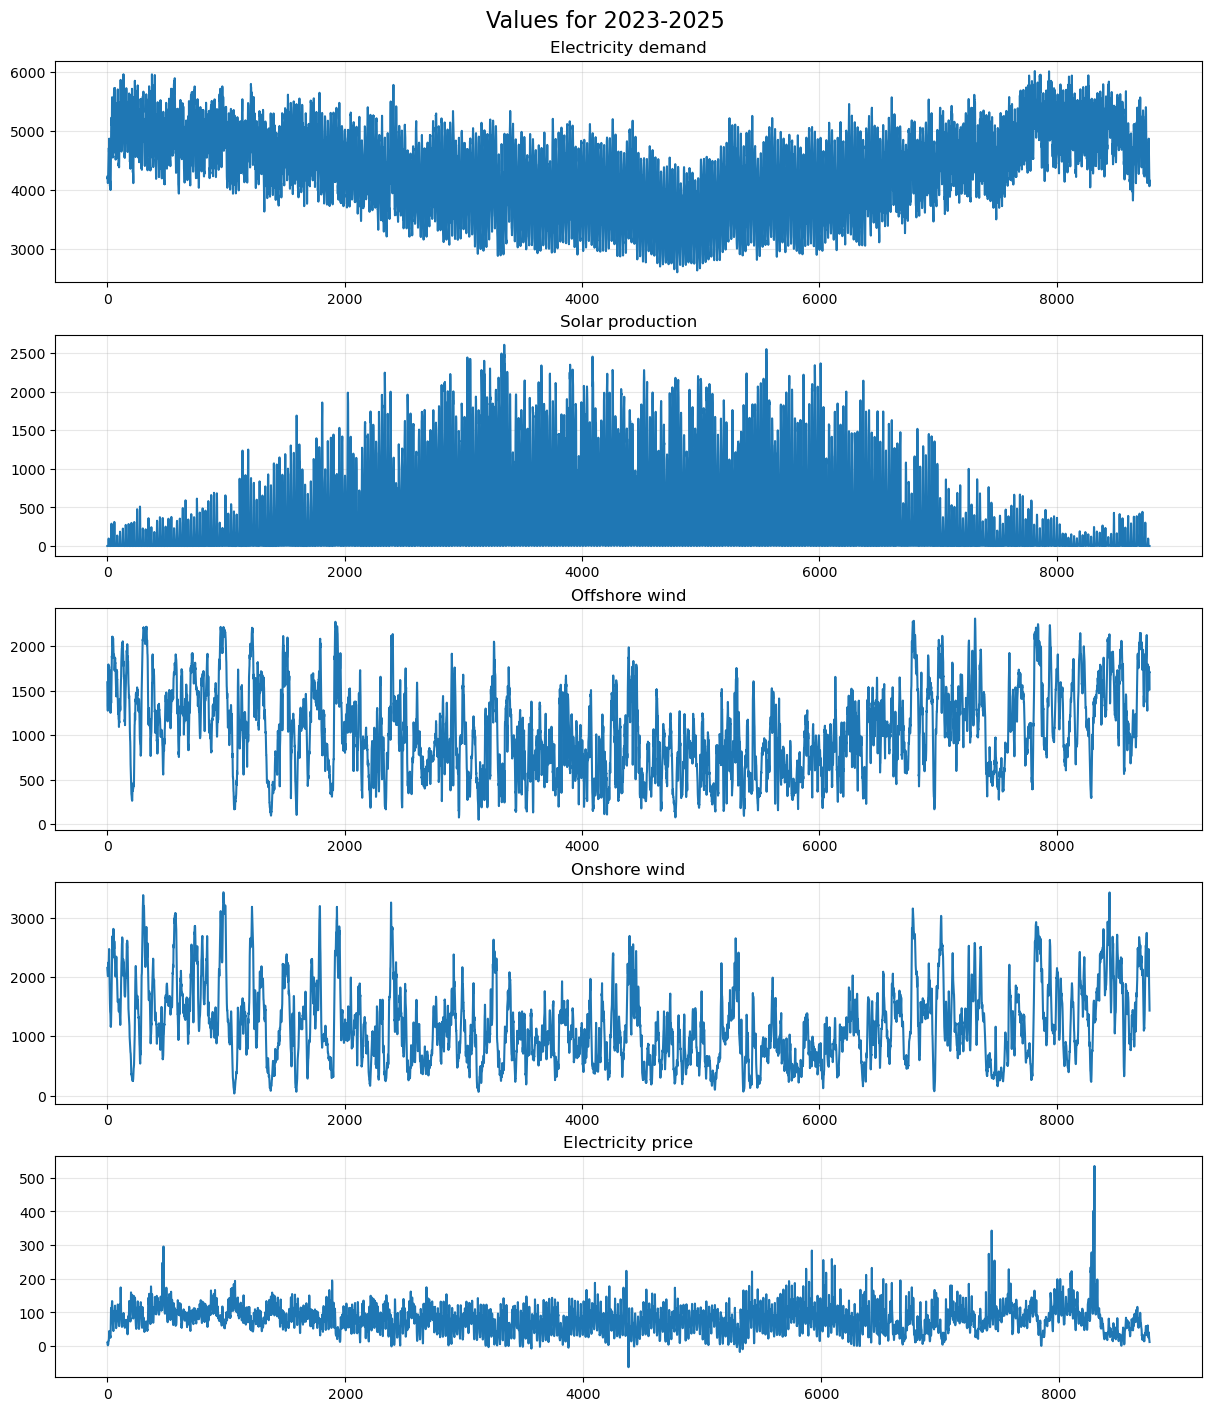

In [ ]:
# labels = [
#     "Electricity demand",
#     "Solar production",
#     "Offshore wind",
#     "Onshore wind",
#     "Electricity price",
# ]

# series_list = [
#     df1.rename(labels[0]),
#     df2.rename(labels[1]),
#     df3.rename(labels[2]),
#     df4.rename(labels[3]),
#     df_avg.rename(labels[4]),
# ]

# fig, axes = plt.subplots(5, 1, figsize=(12, 14), constrained_layout=True)

# for ax, s in zip(axes, series_list):
#     ax.plot(s.to_numpy())            
#     ax.set_title(s.name)
#     ax.grid(True, alpha=0.3)

# fig.suptitle(f"Values for {year_label}", fontsize=16)
# plt.show()